In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt
import re
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import random

In [2]:
# Глобальная фиксация для всех библиотек
SEED = 993
random.seed(SEED)
np.random.seed(SEED)

# 1. ЗАГРУЗКА
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train[train['price_p05'] > 0]
train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

# 2. FEATURE ENGINEERING (БЕЗ ЛАГОВ)
def create_smart_features(df, train_ref=None):
    if train_ref is not None:
        # Средняя цена товара за всё время
        prod_price_map = train_ref.groupby('product_id')['price_p05'].mean().to_dict()
        df['global_prod_avg'] = df['product_id'].map(prod_price_map)
        
        # Средняя цена категории
        cat_price_map = train_ref.groupby('third_category_id')['price_p05'].mean().to_dict()
        df['global_cat_avg'] = df['third_category_id'].map(cat_price_map)
    
    # Относительная представленность
    cat_stores_map = df.groupby('third_category_id')['n_stores'].transform('mean')
    df['store_density_ratio'] = df['n_stores'] / (cat_stores_map + 1e-6)
    
    # Погодные фичи
    df['temp_hum_index'] = df['avg_temperature'] * (df['avg_humidity'] / 100)
    
    # Интенсивность конкуренции
    df['category_breadth'] = df.groupby(['dt', 'third_category_id'])['product_id'].transform('nunique')
    
    return df

train = create_smart_features(train, train_ref=train)
test = create_smart_features(test, train_ref=train)

# 3. ЦИКЛИЧЕСКИЕ ПРИЗНАКИ
def add_cyclical_features(df):
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

train = add_cyclical_features(train)
test = add_cyclical_features(test)

# 4. СПИСОК ПРИЗНАКОВ
cat_features = [
    'management_group_id', 'first_category_id', 
    'activity_flag'
]

features = [
    'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 
    'avg_wind_level', 'week_of_year',
    'month_sin', 'month_cos',
    'global_prod_avg', 'global_cat_avg', 'store_density_ratio',
    'temp_hum_index', 'category_breadth'
] + cat_features

# Заполняем NaN
train[features] = train[features].fillna(train[features].mean(numeric_only=True))
test[features] = test[features].fillna(train[features].mean(numeric_only=True))

# 5. ВАЛИДАЦИЯ (Фиксируем SEED в sample)
train_parts, val_parts = [], []
for _, group in train.groupby('dt'):
    # Здесь зафиксировали 993
    group = group.sample(frac=1, random_state=SEED).reset_index(drop=True)
    split_idx = int(len(group) * 0.8)
    train_parts.append(group.iloc[:split_idx])
    val_parts.append(group.iloc[split_idx:])

train_part = pd.concat(train_parts)
val_part = pd.concat(val_parts)

def calculate_iou(lower_true, upper_true, lower_pred, upper_pred, epsilon=1e-6):
    intersection = np.maximum(0, np.minimum(upper_true, upper_pred) - np.maximum(lower_true, lower_pred))
    union = (upper_true - lower_true + epsilon) + (upper_pred - lower_pred + epsilon) - intersection
    return np.mean(intersection / union)

# Параметры CatBoost (Фиксируем random_seed)
cb_params = {
    'iterations': 2500,
    'learning_rate': 0.03,
    'depth': 7,
    'random_seed': SEED, # Здесь зафиксировали 993
    'verbose': 100,
    'early_stopping_rounds': 200,
}

# Модели
model_low = CatBoostRegressor(loss_function='MAE', **cb_params)
model_high = CatBoostRegressor(loss_function='MAE', **cb_params)

print("Обучение Low...")
model_low.fit(train_part[features], train_part['price_p05'], 
              eval_set=(val_part[features], val_part['price_p05']), 
              cat_features=cat_features, use_best_model=True)

print("Обучение High...")
model_high.fit(train_part[features], train_part['price_p95'], 
               eval_set=(val_part[features], val_part['price_p95']), 
               cat_features=cat_features, use_best_model=True)

# 6. ФИНАЛЬНОЕ ОБУЧЕНИЕ
print("Обучение финальных моделей на полном датасете...")

final_params_low = cb_params.copy()
final_params_low['iterations'] = model_low.get_best_iteration() + 1
final_params_low.pop('early_stopping_rounds', None)

final_params_high = cb_params.copy()
final_params_high['iterations'] = model_high.get_best_iteration() + 1
final_params_high.pop('early_stopping_rounds', None)

# Инициализируем финальные модели с тем же SEED
final_low = CatBoostRegressor(loss_function='MAE', 
                              allow_writing_files=False, 
                              **final_params_low)

final_high = CatBoostRegressor(loss_function='MAE', 
                               allow_writing_files=False, 
                               **final_params_high)

print(f"Финальный запуск Low ({final_params_low['iterations']} ит.)...")
final_low.fit(train[features], train['price_p05'], 
              cat_features=cat_features, 
              verbose=100)

print(f"Финальный запуск High ({final_params_high['iterations']} ит.)...")
final_high.fit(train[features], train['price_p95'], 
               cat_features=cat_features, 
               verbose=100)

# 7. ПРЕДСКАЗАНИЕ И СОХРАНЕНИЕ
print("Создание предсказаний...")
test['price_p05'] = final_low.predict(test[features])
test['price_p95'] = final_high.predict(test[features])

test['price_p95'] = np.maximum(test['price_p95'], test['price_p05'] + 0.001)

submission = test[['row_id', 'price_p05', 'price_p95']].sort_values('row_id')
submission.to_csv('submission.csv', index=False)
print(f"Готово! Результаты зафиксированы с seed {SEED}.")

Обучение Low...
0:	learn: 0.1474645	test: 0.1411393	best: 0.1411393 (0)	total: 184ms	remaining: 7m 39s
100:	learn: 0.0905197	test: 0.0940200	best: 0.0940200 (100)	total: 2.61s	remaining: 1m 2s
200:	learn: 0.0873539	test: 0.0932617	best: 0.0932617 (200)	total: 4.86s	remaining: 55.6s
300:	learn: 0.0856033	test: 0.0930639	best: 0.0930639 (300)	total: 7.11s	remaining: 52s
400:	learn: 0.0841198	test: 0.0929313	best: 0.0929148 (393)	total: 9.48s	remaining: 49.6s
500:	learn: 0.0827702	test: 0.0929207	best: 0.0928793 (433)	total: 11.9s	remaining: 47.4s
600:	learn: 0.0815971	test: 0.0930241	best: 0.0928793 (433)	total: 14.2s	remaining: 44.8s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.09287926301
bestIteration = 433

Shrink model to first 434 iterations.
Обучение High...
0:	learn: 0.1003605	test: 0.0906441	best: 0.0906441 (0)	total: 23.9ms	remaining: 59.7s
100:	learn: 0.0854495	test: 0.0884208	best: 0.0882816 (45)	total: 2.29s	remaining: 54.3s
200:	learn: 0.0825946	test

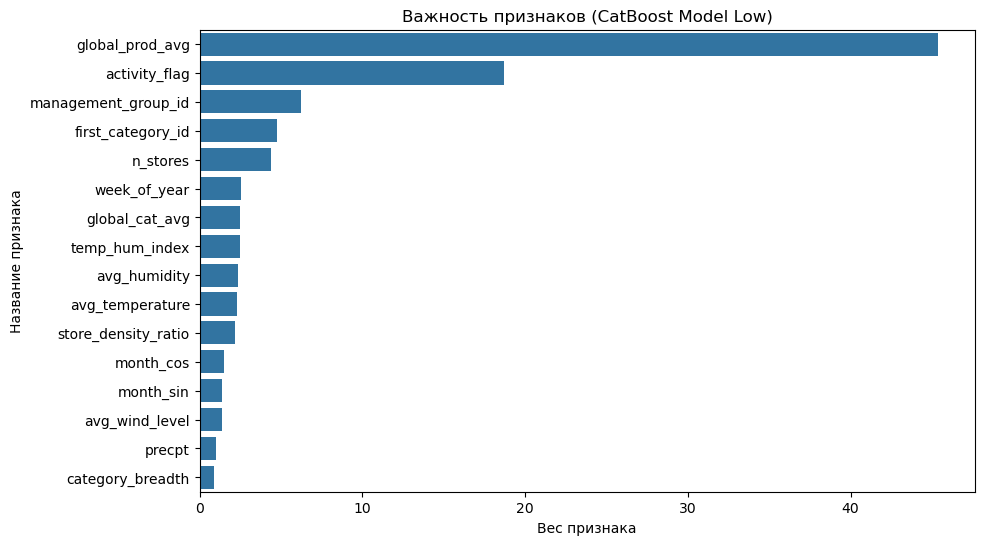

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = final_low.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()